# Libraries | Install

In [35]:
!pip install torch sklearn numpy matplotlib tqdm torchviz ann_visualizer torchsummary tensorboard --quiet

You should consider upgrading via the '/Users/fermibot/PycharmProjects/python-projects/venv/bin/python -m pip install --upgrade pip' command.


# Libraries | Import

In [36]:
import torch
from sklearn.linear_model import LinearRegression
from random import random, randint, choice, normalvariate
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchviz import make_dot
from torchsummary import summary
import pandas as pd

# Functions | Define

In [37]:
def randomize(factor):
    return choice([-1, 1]) * factor * random()


class Config:
    x_n = 10  # NUMBER OF INPUT VARIABLES
    lr = 0.01
    lrs = [0.01, 0.00001]
    epochs = 25
    split_train = 0.8
    shuffle = True
    batch_size = 64
    batch_sizes = [16, 64, 1024]
    device = torch.device("mps")


def print_separator():
    print("\n" + "-" * 100)


config = Config()

# Dataset | Synthesize

$Y_j = \underset{i}{\Sigma} c_{ij}*x_{ij} \mid c_i = 0.1, 0.2, 0.3 ...$

In [38]:
seed_list = [random() for x in range(2 ** 14)]
x_n = config.x_n
coe = [0.1 * x for x in range(1, x_n + 1)]

print([round(x, 4) for x in coe])

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


<Axes: xlabel='original', ylabel='1'>

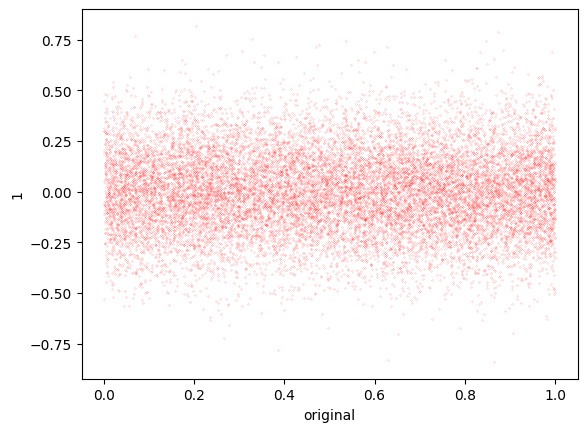

In [39]:
X = [[x + randomize(0.01) for y in range(1, x_n + 1)] for x in seed_list]

X = [[normalvariate() for coe_x in coe] for x in seed_list]
X_y = [[x_i * coe_j + randomize(0.01) for x_i, coe_j in zip(x, coe)] for x in X]
y = [sum([x_i * coe_j + randomize(0.01) for x_i, coe_j in zip(x, coe)]) for x in X]

df = pd.DataFrame(X_y)
df['original'] = seed_list
df.plot.scatter(x='original', y=1, alpha=1, s=0.01, color='red')


# Modeling | Neural Networks

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torch.utils.tensorboard import SummaryWriter

In [41]:
tensor_X = torch.tensor(X, dtype=torch.float32, device=config.device)
tensor_y = torch.tensor(y, dtype=torch.float32, device=config.device)

size_train = int(config.split_train * len(tensor_X))
size_test = len(tensor_X) - size_train
assert size_train + size_test == len(tensor_X)

dataset_train = TensorDataset(tensor_X[:size_train], tensor_y[:size_train])
dataset_test = TensorDataset(tensor_X[size_train:], tensor_y[size_train:])

loader_train = DataLoader(dataset=dataset_train, batch_size=config.batch_size)
loader_test = DataLoader(dataset=dataset_test, batch_size=config.batch_size)

In [42]:
class LinearModel(nn.Module):
    def __init__(self, in_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=in_features, out_features=1, bias=True)

    def forward(self, x):
        return self.linear(x)

## Modeling | Linear Regression | Neural Network | Train

In [43]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

for batch_size in config.batch_sizes:

    loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size)
    loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size)

    for lr in config.lrs:
        model = LinearModel(in_features=config.x_n)
        model.to(device=config.device)

        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        loss_all = []

        for epoch in tqdm(range(config.epochs)):
            # Training phase
            model.train()
            loss_epoch_train = 0.0
            for batch_X, batch_y in loader_train:
                batch_X, batch_y = batch_X.to(config.device), batch_y.to(config.device)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss_batch = criterion(outputs, batch_y.unsqueeze(1))
                loss_batch.backward()
                optimizer.step()

                loss_epoch_train += loss_batch.item()

            # Log training loss
            writer.add_scalar(f"Loss/batch_size_{batch_size}/Train/lr_{lr}", loss_epoch_train / len(loader_train),
                              epoch)

            # Evaluation phase
            model.eval()
            loss_epoch_test = 0.0
            all_preds = []
            all_targets = []

            with torch.no_grad():
                for batch_X, batch_y in loader_test:
                    batch_X, batch_y = batch_X.to(config.device), batch_y.to(config.device)
                    outputs = model(batch_X)
                    loss_batch = criterion(outputs, batch_y.unsqueeze(1))
                    loss_epoch_test += loss_batch.item()

                    all_preds.extend(outputs.cpu().numpy().flatten())
                    all_targets.extend(batch_y.cpu().numpy().flatten())

            # Log test loss
            avg_test_loss = loss_epoch_test / len(loader_test)
            writer.add_scalar(f"Loss/batch_size_{batch_size}/Test/lr_{lr}", avg_test_loss, epoch)

            # Calculate and log R2 score
            r2 = r2_score(all_targets, all_preds)
            writer.add_scalar(f"Metrics/batch_size_{batch_size}/R2/lr_{lr}", r2, epoch)

            # Log weights and biases for analysis
            writer.add_histogram(f"Weights/batch_size_{batch_size}/lr_{lr}", model.linear.weight, epoch)
            writer.add_histogram(f"Bias/batch_size_{batch_size}/lr_{lr}", model.linear.bias, epoch)

            # Log gradients (optional, for debugging)
            for name, param in model.named_parameters():
                if param.grad is not None:
                    writer.add_histogram(f"Gradients/batch_size_{batch_size}/{name}/lr_{lr}", param.grad, epoch)

    writer.close()


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]